In [7]:
!pip install transformers

In [8]:
import transformers
print(transformers.__version__)

4.34.1


In [9]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline

import tensorflow as tf
import pandas as pd
import json
import gc

from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopw = stopwords.words('english')

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df = pd.read_csv("shuffled_data_for_txt_classifications__.csv")
df.head()

,text,category
0,Researching a Ford Ranger for its midsize truc...,cars
1,electric guitar musical instrument,others
2,Interested in a two-bedroom house with a backy...,property
3,Luxury cars offer unparalleled comfort and adv...,cars
4,Real estate agents can provide valuable insigh...,property


In [11]:
df.shape

(999, 2)

In [12]:
df['count'] = df['text'].apply(lambda x: len(x.split()))

In [13]:
df.head()

,text,category,count
0,Researching a Ford Ranger for its midsize truc...,cars,12
1,electric guitar musical instrument,others,4
2,Interested in a two-bedroom house with a backy...,property,8
3,Luxury cars offer unparalleled comfort and adv...,cars,8
4,Real estate agents can provide valuable insigh...,property,13


<Figure size 800x800 with 0 Axes>

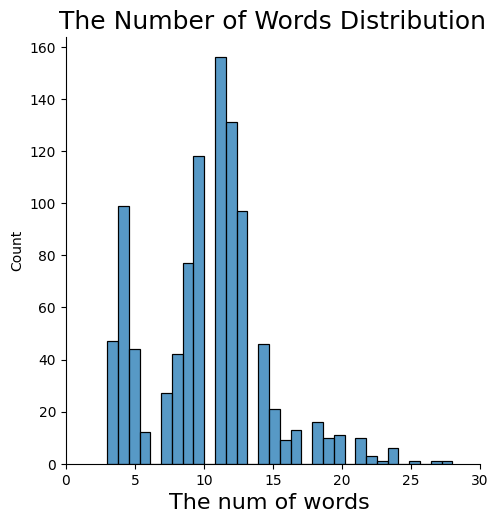

In [14]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 30)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [15]:
category_count = df['category'].value_counts()

categories = category_count.index

categories

Index(['others', 'cars', 'property'], dtype='object')

In [16]:
category_count

others      371
cars        364
property    264
Name: category, dtype: int64

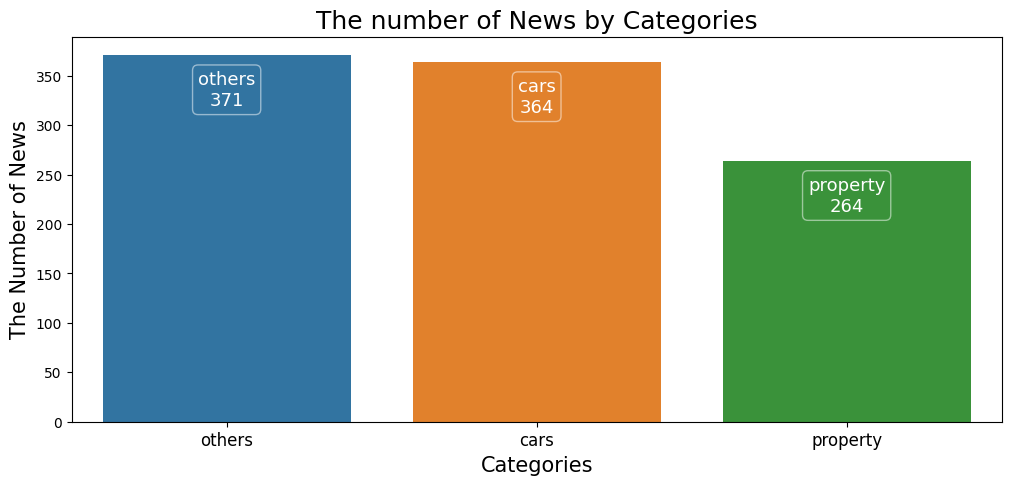

In [17]:
fig = plt.figure(figsize= (12, 5))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [18]:
df['category'].unique()

array(['cars', 'others', 'property'], dtype=object)

In [19]:
df['encoded_text'] = df['category'].astype('category').cat.codes

df.head(10)

,text,category,count,encoded_text
0,Researching a Ford Ranger for its midsize truc...,cars,12,0
1,electric guitar musical instrument,others,4,1
2,Interested in a two-bedroom house with a backy...,property,8,2
3,Luxury cars offer unparalleled comfort and adv...,cars,8,0
4,Real estate agents can provide valuable insigh...,property,13,2
5,Looking for a car with a panoramic sunroof for...,cars,14,0
6,Looking for a house with a modern kitchen.,property,8,2
7,Contemplating a Mazda6 for its stylish design ...,cars,10,0
8,Considering Audi TT for its distinctive design...,cars,10,0
9,contemporary artwork photography,others,3,1


In [20]:
data_texts = df['text'].to_list()
data_labels = df['encoded_text'].to_list()

In [21]:
# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0)

In [22]:
# Tokenize data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [23]:
# Create TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(buffer_size=10000).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(64)

In [24]:
# Build model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [25]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=15)

Epoch 1/15
50/50 [==============================] - 267s 5s/step - loss: 0.7686 - accuracy: 0.8521 - val_loss: 0.1683 - val_accuracy: 0.9850
Epoch 2/15
50/50 [==============================] - 232s 5s/step - loss: 0.0937 - accuracy: 0.9937 - val_loss: 0.0594 - val_accuracy: 0.9900
Epoch 3/15
50/50 [==============================] - 232s 5s/step - loss: 0.0356 - accuracy: 0.9975 - val_loss: 0.0387 - val_accuracy: 0.9900
Epoch 4/15
50/50 [==============================] - 229s 5s/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9950
Epoch 5/15
50/50 [==============================] - 236s 5s/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 0.9950
Epoch 6/15
50/50 [==============================] - 223s 4s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9950
Epoch 7/15
50/50 [==============================] - 230s 5s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9950
Epoch 8/15
50

In [27]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")


1/1 [==============================] - 2s 2s/step - loss: 4.4543e-04 - accuracy: 1.0000
Test accuracy: 1.0


***save the mode + load + test prediction ***

In [28]:
# Save the model and tokenizer
save_directory = "./ClassificationModel"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

('./ClassificationModel/tokenizer_config.json',
 './ClassificationModel/special_tokens_map.json',
 './ClassificationModel/vocab.txt',
 './ClassificationModel/added_tokens.json')

In [29]:
# Load the saved tokenizer and model
tokenizer_fine_tuned = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at ./ClassificationModel were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./ClassificationModel and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
# Test text for prediction
test_text = "i am looking for an apartment for rent"

In [31]:
# Tokenize the test text
predict_input = tokenizer_fine_tuned.encode(
    test_text,
    truncation=True,
    padding=True,
    return_tensors='tf'
)

# Get model prediction
output = model_fine_tuned(predict_input)[0]
prediction_value = tf.argmax(output, axis=1).numpy()[0]

# Output the prediction
print("Predicted category:", prediction_value)
print("Text : "+ test_text)

if int(prediction_value) == 0 :
    print("Predicted category: Cars")

if int(prediction_value) == 1 :
    print("Predicted category: Others")

if int(prediction_value) == 2 :
    print("Predicted category: Property")



Predicted category: 2
Text : i am looking for an apartment for rent
Predicted category: Property


torsh

In [32]:
# Load the saved tokenizer and model
tokenizer_fine_tuned_tf = DistilBertTokenizer.from_pretrained(save_directory)
model_fine_tuned_tf = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

# Test text for prediction
test_text = "BMW X5 with 10 Cylinders, price around 250000 EUR"

# Tokenize the input text
tokenized_inputs = tokenizer_fine_tuned_tf(test_text, truncation=True, padding=True, return_tensors='tf')

# Ensure the input tensors are created correctly
if 'input_ids' in tokenized_inputs and 'attention_mask' in tokenized_inputs:
    with tf.device('/CPU:0'):  # Use appropriate device if available (e.g., '/GPU:0')
        # Pass the tokenized inputs to the model
        output_tf = model_fine_tuned_tf(**tokenized_inputs)

    # Get the predicted class index
    prediction_value_tf = tf.argmax(output_tf.logits, axis=1).numpy()[0]
else:
    # Handle missing input tensors
    prediction_value_tf = None

print("Predicted category (TensorFlow):", prediction_value_tf)


Some layers from the model checkpoint at ./ClassificationModel were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./ClassificationModel and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted category (TensorFlow): 0


download

In [33]:
#!zip -r /content/ClassificationModel_file.zip /content/ClassificationModel/

In [34]:
# # download the folder saved_models
# from google.colab import files
# files.download("/content/ClassificationModel_file.zip")